In [1]:
# Install required packages
!pip install transformers[torch]
!pip install -U datasets
!pip install huggingface_hub
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [13]:
# Reference: https://huggingface.co/docs/transformers/model_sharing
# make sure that you have a token generated from your HuggingFace account

from huggingface_hub import notebook_login
notebook_login()

In [14]:
from datasets import load_dataset

dataset = load_dataset("ridho2401/sa_tapera")

In [16]:
# define the labels

tags = ["POSITIVE","NEUTRAL","NEGATIVE"]
id2label = {0: "POSITIVE", 1: "NEUTRAL", 2:"NEGATIVE"}
label2id = {"POSITIVE": 0, "NEUTRAL": 1, "NEGATIVE":2}
num_labels = 3

In [17]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

In [18]:
# model initialization
max_length = 128

def model_init(model_name):
    global tokenizer
    global data_collator
    global tr_model

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=max_length)

    return model, tokenizer

In [19]:
# preprocessing

def tokenize_function(examples):
    # process the input sequence
    tokenized_input = tokenizer(examples["text"],
                                truncation=True,
                                padding="max_length",
                                max_length=max_length)

    return tokenized_input

def preprocessing():
    tokenized_train_data = dataset["train"].map(tokenize_function, batched=True)
    tokenized_val_data = dataset["validation"].map(tokenize_function, batched=True)
    tokenized_test_data = dataset["test"].map(tokenize_function, batched=True)

    return tokenized_train_data, tokenized_val_data, tokenized_test_data

In [21]:
# define the evaluation metrics

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    true_labels = [tags[l] for l in labels]
    true_predictions = [tags[pr] for pr in pred]

    report = classification_report(true_labels, true_predictions, digits=4)
    acc = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    rec = recall_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    prec = precision_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1 = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro", zero_division=1.0)

    print("Classification Report:\n{}".format(report))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [22]:
# to generate the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def generate_confusion_matrix(true_labels, pred_labels, num_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    labels = [id2label[i] for i in range(num_labels)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.yticks(rotation=0)
    plt.show()

In [23]:
# train the model
import pandas as pd

def train_model(model_name, output_dir, learning_rate, num_epochs):

    model, tokenizer = model_init(model_name)
    train_tokenized, val_tokenized, test_tokenized = preprocessing()

    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit = 1,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        load_best_model_at_end=True,
        push_to_hub=True, # to push to hub during the training
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model(output_dir)
    trainer.push_to_hub(commit_message="Training complete")

    # Get the evaluation results
    trainer.eval_dataset=test_tokenized
    evaluation_results = trainer.evaluate()
    print(evaluation_results)

    # make prediction on the test set
    predictions = trainer.predict(test_tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = test_tokenized["label"]

    # Generate confusion matrix
    generate_confusion_matrix(true_labels, pred_labels, num_labels)

    # Show log history
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.fillna(0)
    log_history = log_history.groupby(["epoch"]).sum()

    log_history[["loss", "eval_loss"]].plot()
    plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.563800,0.412425,0.852740,0.862431,0.842949,0.850439
2,0.194700,0.451848,0.893836,0.911183,0.884012,0.893290
3,0.075400,0.506042,0.890411,0.893735,0.896675,0.895011
4,0.019200,0.569875,0.897260,0.901628,0.896167,0.898107
5,0.009200,0.553365,0.897260,0.903078,0.897264,0.899709


events.out.tfevents.1720712517.bbd8722b8358.652.0:   0%|          | 0.00/8.78k [00:00<?, ?B/s]

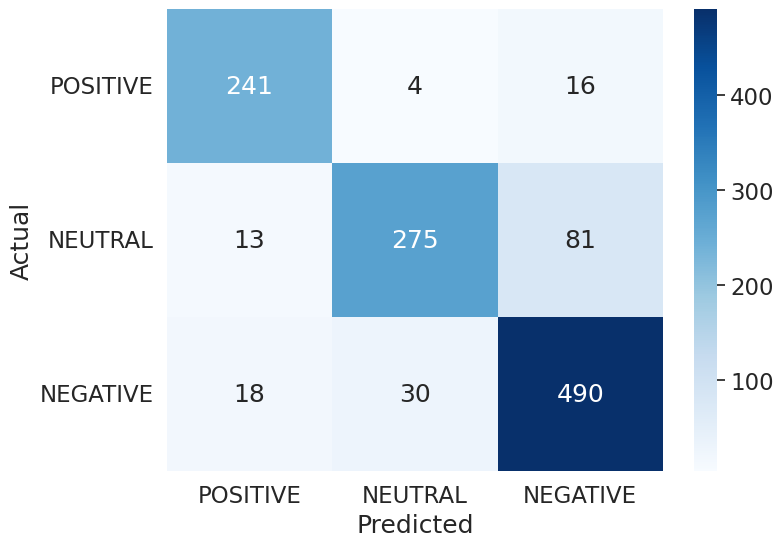

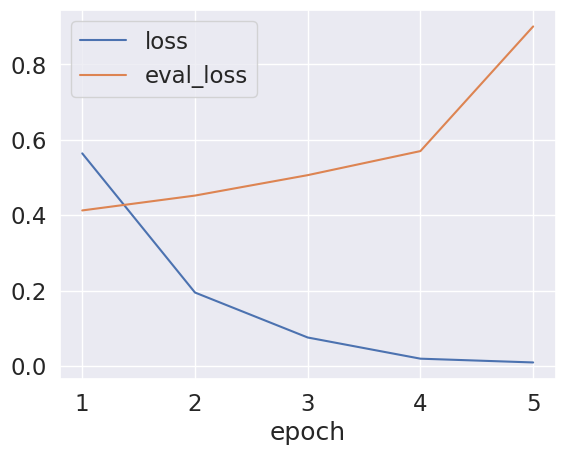

In [24]:
train_model(
    model_name="indolem/indobertweet-base-uncased",
    output_dir="sa-tapera",
    learning_rate=0.0001,
    num_epochs=5
)